#Introduction to Linear Algebra and the world of probablitites


##Singular Value Decomposition




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image

Lets load the image and convert that to a gray-scale version (so that we can treat it just like a 2D matrix). What will happen if its not gray-scale?

Anwser: If the image is not grayscale, it has three (or more) color channels, so it’s a 3D array instead of a 2D matrix.
SVD only works properly on 2D data, so: it will give an error, or produce wrong or messy results (because colors get mixed together).



###Nature in frame - Liwocz Nature Reserve (near Jasło town).

In [2]:
img = Image.open("liwocz.png")
imggray = img.convert('L')

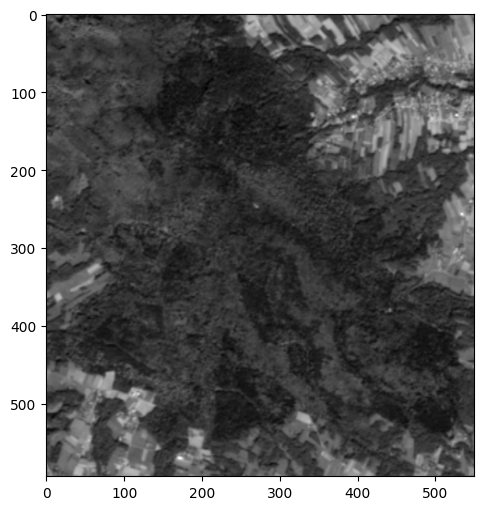

In [3]:
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray')

###SVD

We can directly use the $svd$ command from Numpy to operate SVD on the matrix.

Lets first check how the image will look if we only use a single vector to reconstruct the image.

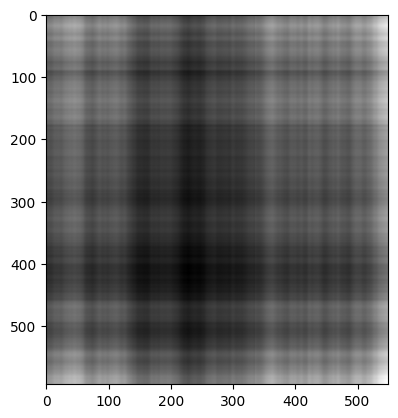

In [4]:
U, sigma, V = np.linalg.svd(imgmat)
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='gray');

In [5]:
U, sigma, V = np.linalg.svd(imgmat)
reconstimg = np.matrix(U[:, :10]) * np.diag(sigma[:10]) * np.matrix(V[:10, :])
plt.imshow(reconstimg, cmap='gray');


Now lets check how does the sigma vector look like.

What do you observe? How many vecotrs can we use to get a decent reconstruction of the image?
What will happen if we omit the first 1-2 vectors (corresponding to the largest eigen values)?

Answer below.



(594, 594)
(550,)


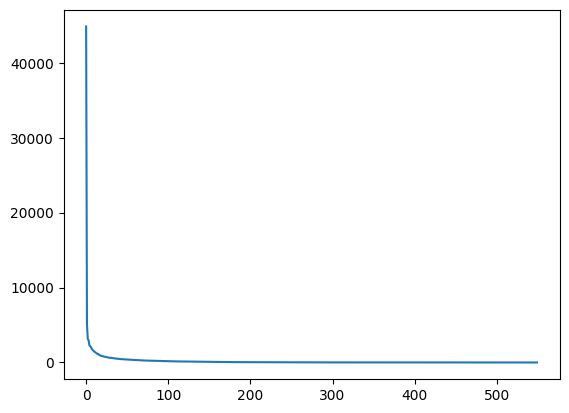

In [6]:
print(U.shape)
print(sigma.shape)
plt.plot(sigma)

###Reconstruction

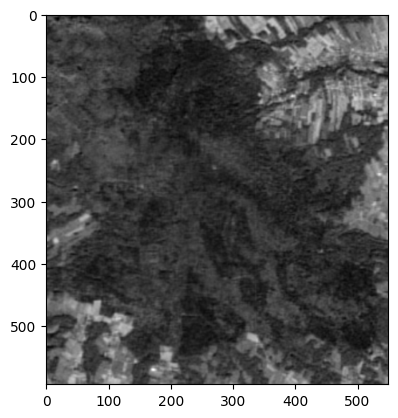

In [7]:
i = 70
j = 0
reconstimg = np.matrix(U[:, j:i]) * np.diag(sigma[j:i]) * np.matrix(V[j:i, :])
plt.imshow(reconstimg, cmap='gray');

###Reconstruction with first few values ommited gives us image with less contrast.

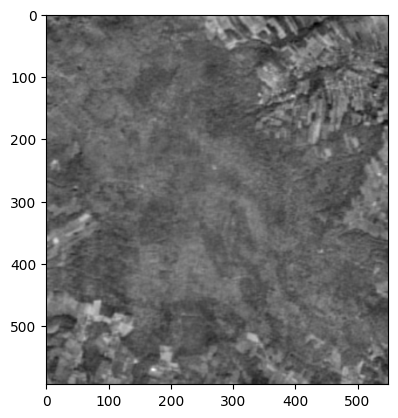

In [8]:
i = 70
j = 3
reconstimg = np.matrix(U[:, j:i]) * np.diag(sigma[j:i]) * np.matrix(V[j:i, :])
plt.imshow(reconstimg, cmap='gray');

###Reconstruction for different singular values

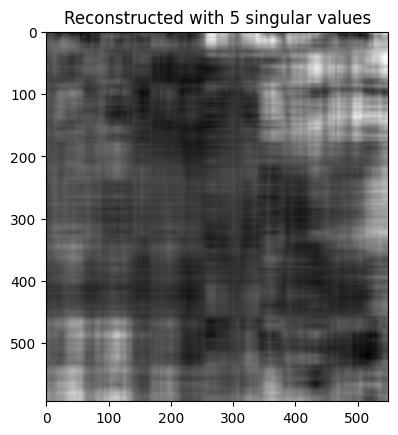

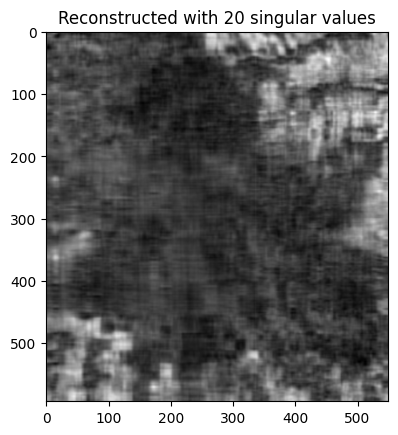

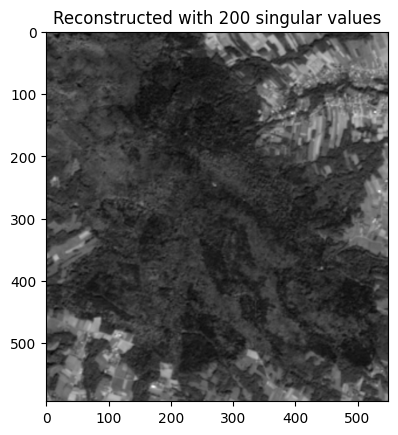

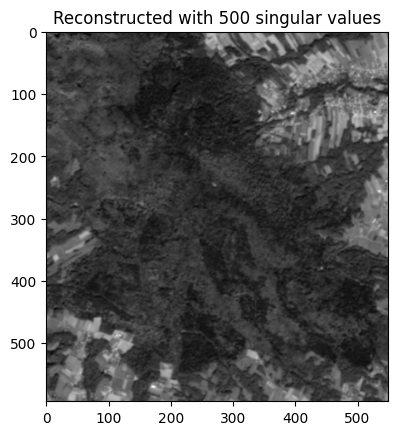

In [9]:
for k in [1, 5, 10, 20, 50, 100, 200, 500]:
    reconst = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
    plt.imshow(reconst, cmap='gray')
    plt.title(f'Reconstructed with {k} singular values')
    plt.show()

###Pictures with reconstruction with 200 and 500 values are really similar to original picture, 100 is enough in my opinion, but one can see the small differences.


###Second example - image of city centre - Jasło.

We perform SVD for a highly urbanized area — the Jasło city.
1. obtain Sentinel-2 imagery,
2. choose the RGB bands and apply normalization,
3. define and extract the area of interest (AOI).


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pyproj import Transformer
from rasterio.windows import from_bounds, Window

b02_path = r"T34UEA_20250920T094041_B02_10m.jp2"
b03_path = r"T34UEA_20250920T094041_B03_10m.jp2"
b04_path = r"T34UEA_20250920T094041_B04_10m.jp2"

lon, lat = 21.470888, 49.744435
dx, dy = 2500, 2500

def point_in_bounds(x, y, bounds):
    xmin, ymin, xmax, ymax = bounds
    return (xmin <= x <= xmax) and (ymin <= y <= ymax)


with rasterio.open(b04_path) as src:
    tfm = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
    x, y = tfm.transform(lon, lat)
    if point_in_bounds(x, y, src.bounds):
        best = (b04_path, b03_path, b02_path, x, y, src.transform, src.width, src.height, src.bounds, src.crs)
    else:
        raise RuntimeError("The point is not within the image bounds.")


b4_path, b3_path, b2_path, x, y, ref_transform, W, H, ref_bounds, ref_crs = best
print("Using tile:", b4_path)

xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy
win = from_bounds(xmin, ymin, xmax, ymax, transform=ref_transform)
win = Window(col_off=max(0, win.col_off),
             row_off=max(0, win.row_off),
             width=min(win.width,  W - max(0, win.col_off)),
             height=min(win.height, H - max(0, win.row_off)))

win = Window(int(round(win.col_off)), int(round(win.row_off)),
             int(round(win.width)),  int(round(win.height)))

with rasterio.open(b4_path) as r:
    b4 = r.read(1, window=win)
with rasterio.open(b3_path) as g:
    b3 = g.read(1, window=win)
with rasterio.open(b2_path) as b:
    b2 = b.read(1, window=win)

rgb = np.dstack([b4, b3, b2]).astype(np.float32)
p = np.percentile(rgb, 99, axis=(0, 1))
p[p == 0] = 1.0
rgb /= p
rgb = np.clip(rgb, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("Jasło Center (S-2 TC, 10 m)")
plt.axis("off")
plt.show()


Using tile: T34UEA_20250920T094041_B04_10m.jp2


###Grayscale image is then used for SVD calculations as shown in the following code cells.

In [13]:
from PIL import Image
import numpy as np

rgb_uint8 = (rgb * 255).astype(np.uint8)
img = Image.fromarray(rgb_uint8)
imggray = img.convert('L')

imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray')

In [14]:
U, sigma, V = np.linalg.svd(imgmat)
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='gray');

In [15]:
print(U.shape)
print(sigma.shape)
plt.plot(sigma)

(500, 500)
(500,)


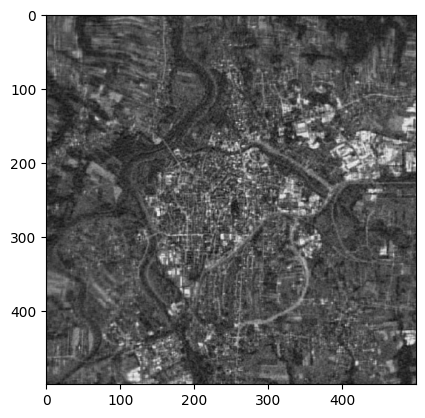

In [16]:
i = 80
j = 0
reconstimg = np.matrix(U[:, j:i]) * np.diag(sigma[j:i]) * np.matrix(V[j:i, :])
plt.imshow(reconstimg, cmap='gray');

###Again, while ommiting some first values, we get less clear vision, it is much more visible in urban areas, where types of land cover can change rapidly

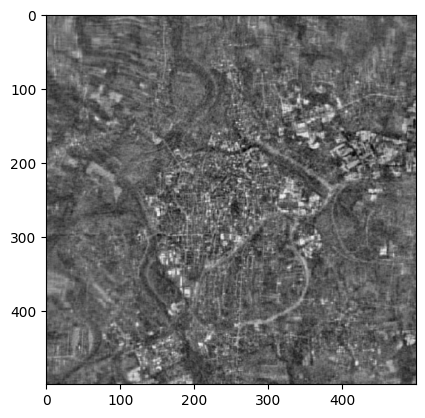

In [17]:
i = 70
j = 3
reconstimg = np.matrix(U[:, j:i]) * np.diag(sigma[j:i]) * np.matrix(V[j:i, :])
plt.imshow(reconstimg, cmap='gray');

###Reconstruction for different singular values

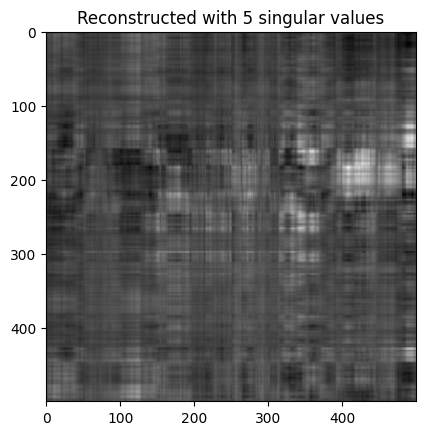

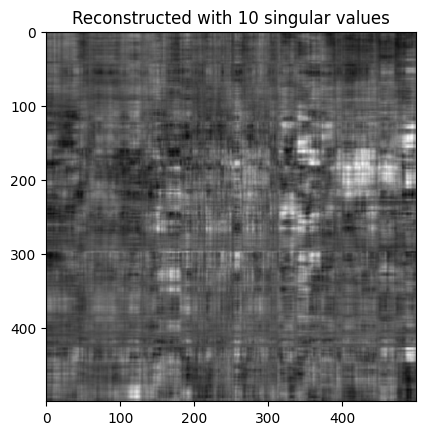

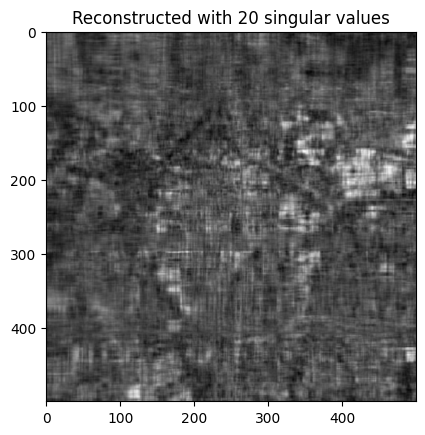

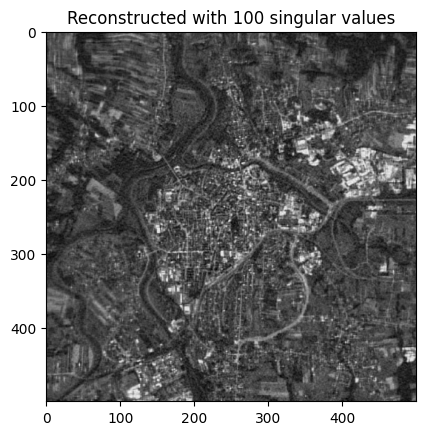

In [18]:
for k in [1, 5, 10, 20, 50, 100, 200, 500]:
    reconst = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
    plt.imshow(reconst, cmap='gray')
    plt.title(f'Reconstructed with {k} singular values')
    plt.show()

I suppose that values of more than 100 are needed to reconstruct image good enough.

Using tile: T34UEA_20250920T094041_B04_10m.jp2


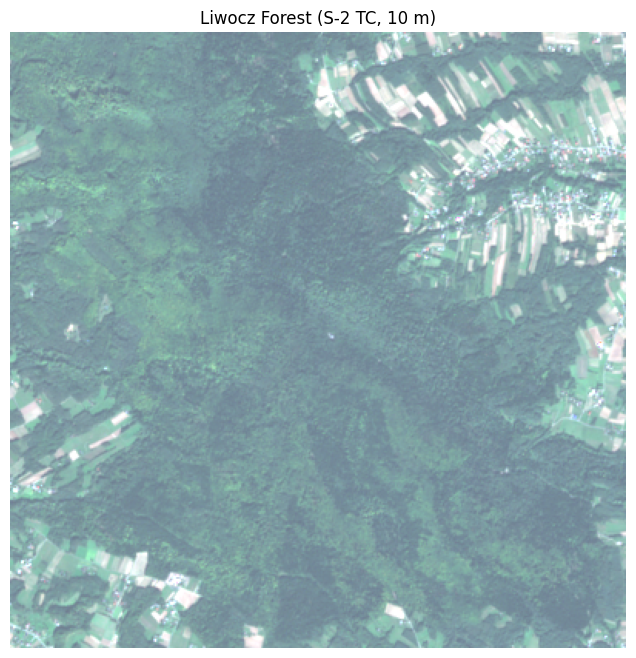

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pyproj import Transformer
from rasterio.windows import from_bounds, Window

b02_path = r"T34UEA_20250920T094041_B02_10m.jp2"
b03_path = r"T34UEA_20250920T094041_B03_10m.jp2"
b04_path = r"T34UEA_20250920T094041_B04_10m.jp2"

lon, lat = 21.350198, 49.812988
dx, dy = 2000, 2000

def point_in_bounds(x, y, bounds):
    xmin, ymin, xmax, ymax = bounds
    return (xmin <= x <= xmax) and (ymin <= y <= ymax)

with rasterio.open(b04_path) as src:
    tfm = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True)
    x, y = tfm.transform(lon, lat)
    if point_in_bounds(x, y, src.bounds):
        best = (b04_path, b03_path, b02_path, x, y, src.transform, src.width, src.height, src.bounds, src.crs)
    else:
        raise RuntimeError("The point is not within the image bounds.")


b4_path, b3_path, b2_path, x, y, ref_transform, W, H, ref_bounds, ref_crs = best
print("Using tile:", b4_path)

xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy
win = from_bounds(xmin, ymin, xmax, ymax, transform=ref_transform)
win = Window(col_off=max(0, win.col_off),
             row_off=max(0, win.row_off),
             width=min(win.width,  W - max(0, win.col_off)),
             height=min(win.height, H - max(0, win.row_off)))

win = Window(int(round(win.col_off)), int(round(win.row_off)),
             int(round(win.width)),  int(round(win.height)))

with rasterio.open(b4_path) as r:
    b4 = r.read(1, window=win)
with rasterio.open(b3_path) as g:
    b3 = g.read(1, window=win)
with rasterio.open(b2_path) as b:
    b2 = b.read(1, window=win)


rgb = np.dstack([b4, b3, b2]).astype(np.float32)
p = np.percentile(rgb, 99, axis=(0, 1))
p[p == 0] = 1.0
rgb /= p
rgb = np.clip(rgb, 0, 1)

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("Liwocz Forest (S-2 TC, 10 m)")
plt.axis("off")
plt.show()


In [21]:
from PIL import Image
import numpy as np

rgb_uint8 = (rgb * 255).astype(np.uint8)
img = Image.fromarray(rgb_uint8)
imggray = img.convert('L')

imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray')

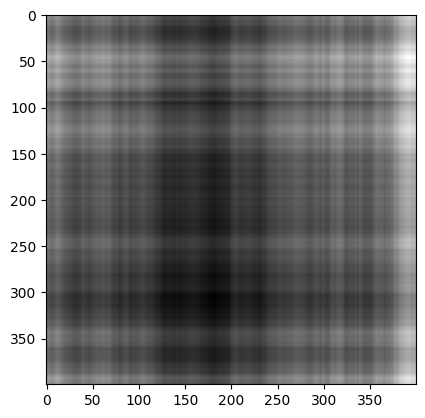

In [22]:
U, sigma, V = np.linalg.svd(imgmat)
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='gray');

(400, 400)
(400,)


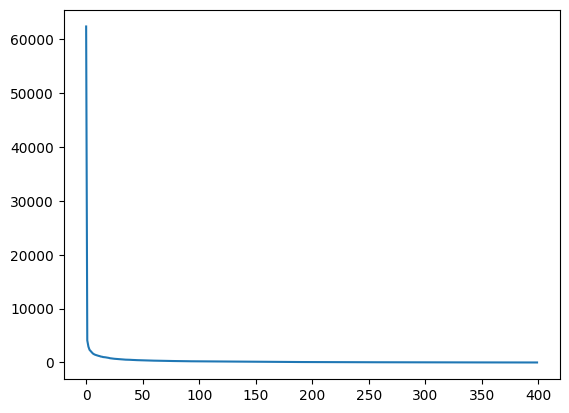

In [23]:
print(U.shape)
print(sigma.shape)
plt.plot(sigma)

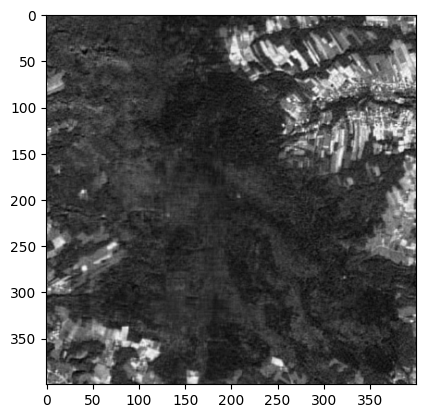

In [24]:
i = 80
j = 0
reconstimg = np.matrix(U[:, j:i]) * np.diag(sigma[j:i]) * np.matrix(V[j:i, :])
plt.imshow(reconstimg, cmap='gray');

In [25]:
i = 80
j = 53
reconstimg = np.matrix(U[:, j:i]) * np.diag(sigma[j:i]) * np.matrix(V[j:i, :])
plt.imshow(reconstimg, cmap='gray');

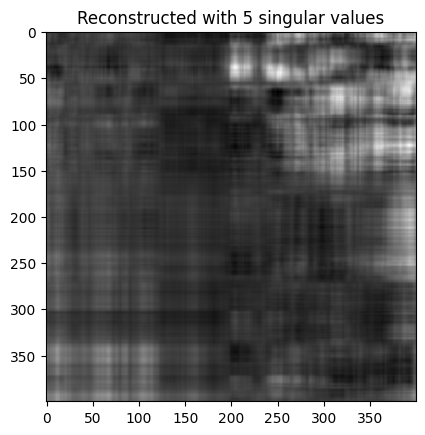

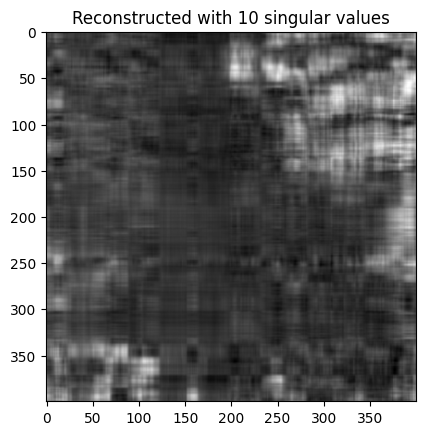

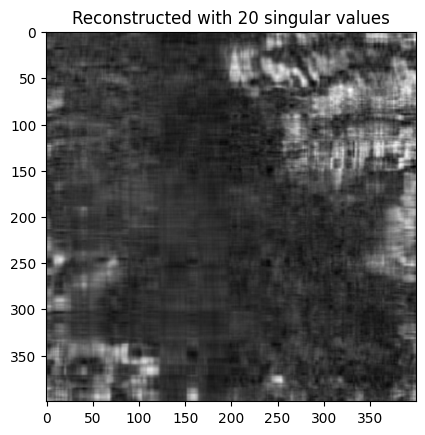

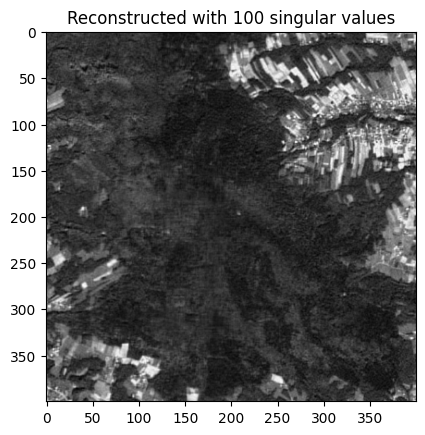

In [26]:
for k in [1, 5, 10, 20, 50, 100, 200, 388]:
    reconst = np.matrix(U[:, :k]) * np.diag(sigma[:k]) * np.matrix(V[:k, :])
    plt.imshow(reconst, cmap='gray')
    plt.title(f'Reconstructed with {k} singular values')
    plt.show()

Key takeaways that answers questions in the instruction:

Using smaller eigenvalues, like the 10th or 11th, leads to worse image quality because they lack important details such as structure and brightness. The largest eigenvalues capture the most essential features of the image, and skipping them results in darker, blurrier images without clear shapes.

For satellite images, the number of eigenvalues needed varies with terrain complexity. Urban areas need more to preserve details like roads and buildings, while rough terrains like forests or permafrost require even more to capture texture. In contrast, simpler areas like oceans need fewer eigenvalues to show a clear image.